# Distributional Semantics and word2vec

Partially adapted from Graham Neubig (CMU)

Previously, we explored neural nets for NLP on the sentiment analysis task.  They have a lot of advantages but a lot of disadvantages.

It was difficult to do much better than logistic regression using a neural net.

One issue was that we were just representing words as indices in a vocabulary and a document was just a vector of numbers representing each word's location in the vocabulary.  This is called the "Bag of Words" (BOW) approach.

We will be using the DyNet package by CMU.

In [6]:
import sys
!{sys.executable} -m pip install dynet

In [5]:
from collections import defaultdict
import time
import random
import dynet as dy
import numpy as np

Create functions to read in the corpus.

This turns all words and tags into indices.

Our data is movie reviews again, but a different dataset.  This data consists of a line from a movie review and then the rating of that movie (0-4 stars).

This makes it a multinomial task, one well-suited in principle to a neural net with softmax layer.

In [79]:
# Functions to read in the corpus
w2i = defaultdict(lambda: len(w2i))  # sets a default value for any key that hasn't been seen before
t2i = defaultdict(lambda: len(t2i)) 
UNK = w2i["<unk>"] # create an index for the unknown token
def read_dataset(filename):
    with open(filename, "r") as f:
        for line in f:
            tag, words = line.lower().strip().split(" ||| ")
            yield ([w2i[x] for x in words.split(" ")], t2i[tag])

In [80]:
# Read in the data
train = list(read_dataset("data/classes/train.txt"))
w2i = defaultdict(lambda: UNK, w2i) # put unknown index on the front
dev = list(read_dataset("data/classes/test.txt"))
nwords = len(w2i)
ntags = len(t2i)

FileNotFoundError: [Errno 2] No such file or directory: 'data/classes/train.txt'

In [ ]:
nwords

18648

This has fewer words than the 45K word vocabulary from last week.  The data's also been curated so that the lines selected from each review communicate the essential thrust of the entire review.

This should make for an easier ML task.

**Possible content warning**: We are going to be examining the data by sampling randomly and I do not know every single word that may occur in this dataset.  Some words may be troubling or offensive.

In [ ]:
len(w2i),w2i # words to indices

(18648,
 defaultdict(<function __main__.<lambda>()>,
             {'<unk>': 0,
              'the': 1,
              'rock': 2,
              'is': 3,
              'destined': 4,
              'to': 5,
              'be': 6,
              '21st': 7,
              'century': 8,
              "'s": 9,
              'new': 10,
              '``': 11,
              'conan': 12,
              "''": 13,
              'and': 14,
              'that': 15,
              'he': 16,
              'going': 17,
              'make': 18,
              'a': 19,
              'splash': 20,
              'even': 21,
              'greater': 22,
              'than': 23,
              'arnold': 24,
              'schwarzenegger': 25,
              ',': 26,
              'jean-claud': 27,
              'van': 28,
              'damme': 29,
              'or': 30,
              'steven': 31,
              'segal': 32,
              '.': 33,
              'gorgeously': 34,
              'elaborate': 35,
  

In [ ]:
t2i # tags to indices

defaultdict(<function __main__.<lambda>()>,
            {'3': 0, '4': 1, '2': 2, '1': 3, '0': 4})

How is the data organized?

In [ ]:
train[0]

([1,
  2,
  3,
  4,
  5,
  6,
  1,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  9,
  17,
  5,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 0)

So an array of word indices followed by a tag index.

Let's create some ways to decode the indices.

In [ ]:
i2w = {v:k for k,v in w2i.items()}
i2w[0] = "<unk>"
i2w

{0: '<unk>',
 1: 'the',
 2: 'rock',
 3: 'is',
 4: 'destined',
 5: 'to',
 6: 'be',
 7: '21st',
 8: 'century',
 9: "'s",
 10: 'new',
 11: '``',
 12: 'conan',
 13: "''",
 14: 'and',
 15: 'that',
 16: 'he',
 17: 'going',
 18: 'make',
 19: 'a',
 20: 'splash',
 21: 'even',
 22: 'greater',
 23: 'than',
 24: 'arnold',
 25: 'schwarzenegger',
 26: ',',
 27: 'jean-claud',
 28: 'van',
 29: 'damme',
 30: 'or',
 31: 'steven',
 32: 'segal',
 33: '.',
 34: 'gorgeously',
 35: 'elaborate',
 36: 'continuation',
 37: 'of',
 38: 'lord',
 39: 'rings',
 40: 'trilogy',
 41: 'so',
 42: 'huge',
 43: 'column',
 44: 'words',
 45: 'can',
 46: 'not',
 47: 'adequately',
 48: 'describe',
 49: 'co-writer\\/director',
 50: 'peter',
 51: 'jackson',
 52: 'expanded',
 53: 'vision',
 54: 'j.r.r.',
 55: 'tolkien',
 56: 'middle-earth',
 57: 'singer\\/composer',
 58: 'bryan',
 59: 'adams',
 60: 'contributes',
 61: 'slew',
 62: 'songs',
 63: '--',
 64: 'few',
 65: 'potential',
 66: 'hits',
 67: 'more',
 68: 'simply',
 69: 'int

In [ ]:
i2t = {v:k for k,v in t2i.items()}
i2t

{0: '3', 1: '4', 2: '2', 3: '1', 4: '0'}

In [ ]:
def decode_sample(sample):
    return [i2w[x] if x in i2w else "<unk>" for x in sample[0]], i2t[sample[1]]

Now it'll be easier to interpret a sample.

In [ ]:
words, tag = decode_sample(train[10])
" ".join(words), tag

('good fun , good action , good acting , good dialogue , good pace , good cinematography .',
 '4')

## DyNet

DyNet is a neural network toolkit produced by Carnegie Mellon University.  While not as well-known as, e.g., TensorFlow or PyTorch, it does most of the same things.

Like 3D modeling software or carcinization ([the process by which nature evolves a crab](https://en.wikipedia.org/wiki/Carcinisation)), most neural network toolkits get you to the same place different ways.

DyNet also runs on a **computation graph** (like TF or PyTorch).

A computation graph is a directed graph where the nodes correspond to operations or variables. Variables can feed their value into operations, and operations can feed their output into other operations. This way, every node in the graph defines a function of the variables.

DyNet builds its computational graph on the fly. This makes variable-input and variable-output models simple to implement. It also makes defining models very compact.

Let's build a DyNet model and examine it.

In [ ]:
# Start DyNet and define trainer
model = dy.Model()
trainer = dy.AdamTrainer(model)

model.parameters_list()

[]

Right now the model is empty.

There are two types of parameters: **Lookup Parameters** and just plain **Parameters**

LookupParameters represents a table of parameters.

They are used to embed a set of discrete objects (e.g. word embeddings). These are sparsely updated.

Parameters are things that are optimized. in contrast to a system like Torch where computational modules may have their own parameters, in DyNet parameters are just parameters.

In [ ]:
# Define the model
W_sm = model.add_lookup_parameters((nwords, ntags)) # Word weights
b_sm = model.add_parameters((ntags))                # Softmax bias

In [ ]:
print("nwords",nwords)
print("ntags",ntags)

model.parameters_list()

nwords 18648
ntags 5


[Parameter /_1]

That's a 1-element list.  Let's see what's in it.

In [ ]:
model.parameters_list()[0].as_array()

array([ 0.7385484 , -0.63852179,  0.11619706, -0.02760649, -0.71378034])

In [ ]:
b_sm.as_array()

array([ 0.7385484 , -0.63852179,  0.11619706, -0.02760649, -0.71378034])

Those are my softbax biases.  There are 5 values for the 5 tags, or 5 output values of the model.

In [ ]:
model.lookup_parameters_list()

[LookupParameter /_0]

In [ ]:
model.lookup_parameters_list()[0].as_array()

array([[ 0.00920034, -0.00244009,  0.01366456, -0.01458473,  0.00298795],
       [-0.01655894,  0.00119357,  0.01582853, -0.00662631, -0.00664929],
       [-0.00122233,  0.00199532,  0.01677718, -0.00842867, -0.00135602],
       ...,
       [ 0.01266512,  0.01045685,  0.01523736,  0.01097631, -0.00882406],
       [-0.0073431 , -0.00154144,  0.00119418,  0.00633218, -0.01244928],
       [ 0.00456406,  0.00715536, -0.01556415, -0.01576499,  0.00834564]])

That looks big.

In [ ]:
model.lookup_parameters_list()[0].as_array().shape

(18648, 5)

It is big.

In [ ]:
W_sm.as_array()

array([[ 0.00920034, -0.00244009,  0.01366456, -0.01458473,  0.00298795],
       [-0.01655894,  0.00119357,  0.01582853, -0.00662631, -0.00664929],
       [-0.00122233,  0.00199532,  0.01677718, -0.00842867, -0.00135602],
       ...,
       [ 0.01266512,  0.01045685,  0.01523736,  0.01097631, -0.00882406],
       [-0.0073431 , -0.00154144,  0.00119418,  0.00633218, -0.01244928],
       [ 0.00456406,  0.00715536, -0.01556415, -0.01576499,  0.00834564]])

These are weights associated with every word (18,648 of them) and every tag or class (5 of them).  According to this, the first word in the vocabulary should have almost no association with any particular tag (all values close to zero).

What are the highest-weighted words for each category?

In [ ]:
np.argmax(W_sm.as_array(), axis=0)

array([17154, 18142, 10535,  8916, 18515])

In [ ]:
highest_weighted_word_idx = np.argmax(W_sm.as_array(), axis=0)[t2i['0']]
highest_weighted_word_idx = highest_weighted_word_idx if highest_weighted_word_idx in i2w else 0 
i2w[highest_weighted_word_idx], W_sm.as_array()[highest_weighted_word_idx][t2i['0']]

('<unk>', 0.002987946616485715)

In [ ]:
highest_weighted_word_idx = np.argmax(W_sm.as_array(), axis=0)[t2i['1']]
highest_weighted_word_idx = highest_weighted_word_idx if highest_weighted_word_idx in i2w else 0 
i2w[highest_weighted_word_idx], W_sm.as_array()[highest_weighted_word_idx][t2i['1']]

('frei', 0.017933908849954605)

In [ ]:
highest_weighted_word_idx = np.argmax(W_sm.as_array(), axis=0)[t2i['2']]
highest_weighted_word_idx = highest_weighted_word_idx if highest_weighted_word_idx in i2w else 0 
i2w[highest_weighted_word_idx], W_sm.as_array()[highest_weighted_word_idx][t2i['2']]

('drug-related', 0.017933925613760948)

In [ ]:
highest_weighted_word_idx = np.argmax(W_sm.as_array(), axis=0)[t2i['3']]
highest_weighted_word_idx = highest_weighted_word_idx if highest_weighted_word_idx in i2w else 0 
i2w[highest_weighted_word_idx], W_sm.as_array()[highest_weighted_word_idx][t2i['3']]

('<unk>', 0.009200339205563068)

In [ ]:
highest_weighted_word_idx = np.argmax(W_sm.as_array(), axis=0)[t2i['4']] 
highest_weighted_word_idx = highest_weighted_word_idx if highest_weighted_word_idx in i2w else 0 
i2w[highest_weighted_word_idx], W_sm.as_array()[highest_weighted_word_idx][t2i['4']]

('<unk>', -0.002440092386677861)

Weights are initialized uniformly, so the highest-weighted word for each category is pretty random, and also the weight associated with that word is almost identical for all of the highest-weighted words per tag.

### Expressions

Expressions are used as an interface to the various functions that can be used to build computation graphs.

In [ ]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# Note: please import dynet_config before import dynet
import dynet_config
# set random seed to have the same result each time
dynet_config.set(random_seed=0)

## ==== Create a new computation graph
# (There is a single global computation graph that is used at any point.
# dy.renew_cg() clears the current one and starts a new one)
dy.renew_cg();

In [ ]:
# create a scalar expression.
value = 5.0
x = dy.scalarInput(value)
x

expression 0/1

In [ ]:
# create a vector expression.
dimension = 3
v = dy.vecInput(dimension)
v.set([1,2,3])
v

expression 1/1

In [ ]:
# create a matrix expression from a list
mat1 = dy.inputTensor([[1,2], [3,4]]) # Row major

# or, using a numpy array
mat2 = dy.inputTensor(np.array([[1,2], [3,4]]))

mat3 = dy.inputTensor(np.zeros((2,3)))
mat1,mat2,mat3

(expression 2/1, expression 3/1, expression 4/1)

In [ ]:
## ==== Calculate the value of an expression.
# This will run the forward step of the neural network.
print(mat1.value())
print(mat1.npvalue())    # as numpy array
print(mat2.value())
print(mat3.value())
print(v.vec_value())     # as vector, if vector
print(x.scalar_value())  # as scalar, if scalar
print(x.value())         # choose the correct one

[[1. 2.]
 [3. 4.]]
[[1. 2.]
 [3. 4.]]
[[1. 2.]
 [3. 4.]]
[[0. 0. 0.]
 [0. 0. 0.]]
[1.0, 2.0, 3.0]
5.0
5.0


### Some Function Definitions

* **`dy.renew_cg()`**: Resets the computation graph
* **`dy.esum(...)`**: Elementwise sum
* **`dy.lookup(...)`**: Create an expression from lookup parameters
* **`dy.parameter(...)`**: Add parameters to computation graph

In [ ]:
# A function to calculate scores for one value
def calc_scores(words):
    dy.renew_cg()
    score = dy.esum([dy.lookup(W_sm, x) for x in words])
    b_sm_exp = dy.parameter(b_sm)
    return score + b_sm_exp

Now I'm ready to train and test.

In [ ]:
epochs = 100
for ITER in range(epochs):
    # Perform training
    random.shuffle(train)
    train_loss = 0.0
    start = time.time()
    for words, tag in train:
        my_loss = dy.pickneglogsoftmax(calc_scores(words), tag) # negative softmax log likelihood
        train_loss += my_loss.value()
        my_loss.backward()
        trainer.update()
    if ITER % int(epochs/10) == 0:
        print("iter %r: train loss/sent=%.4f, time=%.2fs" % (ITER, train_loss/len(train), time.time()-start))
    # Perform testing
    test_correct = 0.0
    for words, tag in dev:
        scores = calc_scores(words).npvalue()
        predict = np.argmax(scores)
        if predict == tag:
            test_correct += 1
    if ITER % int(epochs/10) == 0:
        print("iter %r: test acc=%.4f" % (ITER, test_correct/len(dev)))

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.
iter 0: train loss/sent=1.5076, time=0.21s
iter 0: test acc=0.3579
iter 10: train loss/sent=0.8491, time=0.16s
iter 10: test acc=0.4109
iter 20: train loss/sent=0.6537, time=0.16s
iter 20: test acc=0.4131
iter 30: train loss/sent=0.5470, time=0.16s
iter 30: test acc=0.4131
iter 40: train loss/sent=0.4773, time=0.16s
iter 40: test acc=0.4109
iter 50: train loss/sent=0.4273, time=0.16s
iter 50: test acc=0.4059
iter 60: train loss/sent=0.3888, time=0.17s
iter 60: test acc=0.4032
iter 70: train loss/sent=0.3582, time=0.19s
iter 70: test acc=0.4059
iter 80: train loss/sent=0.3324, time=0.18s
iter 80: test acc=0.4018
iter 90: train loss/sent=0.3105, time=0.16s
iter 90: test acc=0.3964


Let's look at some of the samples, the first 20.

In [ ]:
for i in range(20):
    words, tag = decode_sample(dev[i])
    print((" ".join(words), tag))

('effective but <unk> biopic', '2')
('if you sometimes like to go to the movies to have fun , wasabi is a good place to start .', '3')
("emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .", '4')
('the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .', '2')
('offers that rare combination of entertainment and education .', '4')
('perhaps no picture ever made has more literally <unk> that the road to hell is paved with good intentions .', '3')
("steers turns in a snappy screenplay that <unk> at the edges ; it 's so clever you want to hate it .", '3')
('but he somehow pulls it off .', '3')
('take care of my cat offers a refreshingly different slice of asian cinema .', '3')
('this is a film well worth seeing , talking and singing heads and all .', '4')
('what really surprises about wisegirls is its low-key quality and genuine tenderness .', '3'

And the results of those samples.

In [ ]:
print("Correct\tPredicted")
for i in range(20):
    _, tag = decode_sample(dev[i])
    scores = calc_scores(dev[i][0]).npvalue()
    predict = np.argmax(scores)
    print(tag,"\t",i2t[predict])

Correct	Predicted
2 	 3
3 	 3
4 	 4
2 	 4
4 	 4
3 	 2
3 	 2
3 	 2
3 	 4
4 	 4
3 	 3
3 	 3
4 	 4
2 	 1
3 	 1
2 	 3
4 	 4
3 	 4
4 	 3
4 	 4


So... okay.  Lots of off-by-1 errors, but this is a subjective task.  What's a 3-star review vs. a 4-star review?

Test accuracy appears to be about 40%.  Is this good?

For a 5-class categorization task, it is about 20% better than chance.  That actually is good by most measures.

Let's examine the most predictive words for each class.  I'm going to do this by examining the trained weights.  We'll take the `argmax` across all columns.  We have 18,648 rows, each one representing a word, now weighted according to how strongly they predict each of the five labels.

We should expect to see two things:

1. The highest weighted word per category should be different from what we observed earlier.

2. The weights associated with those words should also be different, and more obviously associated with a particular category.

In [ ]:
np.argmax(W_sm.as_array(), axis=0)

array([ 1691,   874,    65, 11285,  2603])

Sure enough, the word indices have changed!

In [ ]:
print(i2t)
for tag in sorted(t2i.keys()):
    highest_weighted_word_idx = np.argmax(W_sm.as_array(), axis=0)[t2i[tag]]
    print(tag,highest_weighted_word_idx,i2w[highest_weighted_word_idx], W_sm.as_array()[highest_weighted_word_idx])

{0: '3', 1: '4', 2: '2', 3: '1', 4: '0'}
0 2603 worst [-1.20813549 -1.99004316 -0.54519242  0.02700192  1.31345379]
1 11285 wannabe [-0.8572554  -0.86759192 -0.89146626  1.03033304 -0.50137949]
2 65 potential [-0.31248748 -0.41788697  0.87740469 -0.7367509  -0.12538719]
3 1691 old-fashioned [ 1.09442759 -0.56487101 -0.62937176 -0.51559848 -1.22022521]
4 874 entertaining [ 0.34187451  1.30591071 -0.68952763 -0.88704032 -0.89838171]


"worst" is the word most associated with a 0-star review, while "entertaining" is most predictive of a 4-star review.

We can look at some of the reivews of a give rating that contain the most-predictive word.  

In [ ]:
t_idx = t2i['4']
w_idx = np.argmax(W_sm.as_array(), axis=0)[t_idx]

for (ws, t) in [(ws, t) for (ws, t) in train if t == t_idx and w_idx in ws]:
    words, tag = decode_sample((ws,t))
    print(" ".join(words), tag)

jones has delivered a solidly entertaining and moving family drama . 4
a wildly entertaining scan of evans ' career . 4
manages to be both hugely entertaining and uplifting . 4
a terrifically entertaining specimen of spielbergian sci-fi . 4
while general audiences might not come away with a greater knowledge of the facts of cuban music , they 'll be treated to an impressive and highly entertaining celebration of its sounds . 4
overall , it 's a very entertaining , thought-provoking film with a simple message : god is love . 4
like the best 60 minutes exposé , the film -lrb- at 80 minutes -rrb- is actually quite entertaining . 4
`` red dragon '' is entertaining . 4
what a bewilderingly brilliant and entertaining movie this is . 4
an enthralling , entertaining feature . 4
richly entertaining and suggestive of any number of metaphorical readings . 4
i encourage young and old alike to go see this unique and entertaining twist on the classic whale 's tale -- you wo n't be sorry ! 4
this qui

We can do the same thing by looking at the *least* predictive words per category, which could also be pretty predictive of the *opposite* category(ies).

In [ ]:
print(i2t)
for tag in sorted(t2i.keys()):
    lowest_weighted_word_idx = np.argmin(W_sm.as_array(), axis=0)[t2i[tag]] # using argmin now
    print(tag,lowest_weighted_word_idx,i2w[lowest_weighted_word_idx], W_sm.as_array()[lowest_weighted_word_idx])

{0: '3', 1: '4', 2: '2', 3: '1', 4: '0'}
0 672 best [-0.09597449  1.12240946 -0.15426145 -0.53366077 -2.62302446]
1 854 solid [ 0.60165358  0.66754663 -0.50576502 -2.3923192  -2.19553757]
2 1332 thoroughly [ 0.43557012 -0.39067206 -1.82458651  0.07248002  0.24447037]
3 4569 mess [-2.10412288 -1.9563787  -0.1827624   0.17761146  0.95808285]
4 475 ? [-0.66050559 -2.39071202  0.72981125  0.5020591  -0.40074319]


So "best" is least associated with a 0-star review, and the "?" is least associated with a 4-star review, with a weight of ~-2.4.

In [ ]:
t_idx = t2i['4']
w_idx = np.argmin(W_sm.as_array(), axis=0)[t_idx]

for (ws, t) in [(ws, t) for (ws, t) in train if t == t_idx and w_idx in ws]:
    words, tag = decode_sample((ws,t))
    print(" ".join(words), tag)

a highly spirited , imaginative kid 's movie that broaches neo-augustinian theology : is god stuck in heaven because he 's afraid of his best-known creation ? 4
could i have been more geeked when i heard that apollo 13 was going to be released in imax format ? 4


Only a very few 4-star reviews have question marks.

In [ ]:
t = 2 # searching for the least predictive word for category t
t_idx = t2i[str(-t+4)]
w_idx = np.argmin(W_sm.as_array(), axis=0)[t2i[str(t)]] # looking for reviews of the opposite category that contain that word

for (ws, t) in [(ws, t) for (ws, t) in train if t == t_idx and w_idx in ws]:
    words, tag = decode_sample((ws,t))
    print(" ".join(words), tag)

A ton of 4-star reviews contain "best."  More than contain "entertaining," actually.  Why is "entertaining" more highly weighted for 4-stars?

We can also try this for other ratings.  (Switch `t=4` above for another number).

Try `t=2`.  You'll find that few or no 2-star reviews contain the least associated word with category 2 (which may change as we train). Let's look for reviews that contain that word.

In [ ]:
w_idx = np.argmin(W_sm.as_array(), axis=0)[2]

for (ws, t) in [(ws, t) for (ws, t) in train if w_idx in ws]:
    words, tag = decode_sample((ws,t))
    print(" ".join(words), tag)

this loud and thoroughly obnoxious comedy about a pair of squabbling working-class spouses is a deeply unpleasant experience . 0
it 's a hellish , numbing experience to watch , and it does n't offer any insights that have n't been thoroughly debated in the media already , back in the dahmer heyday of the mid - '90s . 1
me no lika da accents so good , but i thoroughly enjoyed the love story . 3
not only does the thoroughly formulaic film represent totally exemplify middle-of-the-road mainstream , it also represents glossy hollywood at its laziest . 0
the film 's thoroughly recycled plot and tiresome jokes ... drag the movie down . 1
despite besson 's high-profile name being wasabi 's big selling point , there is no doubt that krawczyk deserves a huge amount of the credit for the film 's thoroughly winning tone . 3
a retread of material already thoroughly plumbed by martin scorsese . 1
a first-class , thoroughly involving b movie that effectively combines two surefire , beloved genres --

So, we can see that this word doesn't appear in many or any) 2-star reviews (average), but appears all over the place in all of the other categories.

In [ ]:
lowest_word_2_idx = np.argmin(W_sm.as_array(), axis=0)[2]
lowest_word_2 = i2w[np.argmin(W_sm.as_array(), axis=0)[t2i['2']]]

So the meaning (or polarity, or sentiment) of this word will depend on what it modifies, or what it cooccurs with.

In [ ]:
print("\"%s\" + X" % lowest_word_2)
for (ws, t) in [(ws, t) for (ws, t) in train if lowest_word_2_idx in ws]:
    words, tag = decode_sample((ws,t))
    print(" ".join([words[words.index(lowest_word_2)],words[words.index(lowest_word_2)+1]]), tag)

"thoroughly" + X
thoroughly obnoxious 0
thoroughly debated 1
thoroughly enjoyed 3
thoroughly formulaic 0
thoroughly recycled 1
thoroughly winning 3
thoroughly plumbed 1
thoroughly involving 4
thoroughly unrewarding 0
thoroughly winning 3
thoroughly dislikable 1
thoroughly satisfying 3
thoroughly engaging 4
thoroughly enjoyable 3
thoroughly unfaithful 3
thoroughly dull 0
thoroughly enjoyed 3
thoroughly engrossing 1
thoroughly vacuous 0
thoroughly enjoyable 3
thoroughly entertaining 4
thoroughly , 4
thoroughly awful 0
thoroughly modern 1
thoroughly overbearing 3
thoroughly awful 0


In [ ]:
print("X + \"%s\"" % lowest_word_2)
for (ws, t) in [(ws, t) for (ws, t) in train if lowest_word_2_idx in ws]:
    words, tag = decode_sample((ws,t))
    print(" ".join([words[words.index(lowest_word_2)-1],words[words.index(lowest_word_2)]]), tag)

X + "thoroughly"
and thoroughly 0
been thoroughly 1
i thoroughly 3
the thoroughly 0
's thoroughly 1
's thoroughly 3
already thoroughly 1
, thoroughly 4
how thoroughly 0
, thoroughly 3
, thoroughly 1
but thoroughly 3
a thoroughly 4
a thoroughly 3
and thoroughly 3
and thoroughly 0
crew thoroughly 3
. thoroughly 1
about thoroughly 0
. thoroughly 3
a thoroughly 4
so thoroughly 4
a thoroughly 0
a thoroughly 1
and thoroughly 3
. thoroughly 0


So, if I could capture something about the context a word occurs in, I might capture more about its meaning, and its predictive power.

## Continuous Bag of Words

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words).

e.g., "Mary had a little #### whose #### was white as snow."

In [ ]:
# Define the model
EMB_SIZE = 64
W_emb = model.add_lookup_parameters((nwords, EMB_SIZE)) # Word embeddings
W_sm = model.add_parameters((ntags, EMB_SIZE))          # Softmax weights
b_sm = model.add_parameters((ntags))                      # Softmax bias

In [ ]:
# A function to calculate scores for one value
def calc_scores(words):
    dy.renew_cg()
    cbow = dy.esum([dy.lookup(W_emb, x) for x in words])
    W_sm_exp = dy.parameter(W_sm)
    b_sm_exp = dy.parameter(b_sm)
    return W_sm_exp * cbow + b_sm_exp

In [ ]:
epochs = 100
for ITER in range(epochs):
    # Perform training
    random.shuffle(train)
    train_loss = 0.0
    start = time.time()
    for words, tag in train:
        my_loss = dy.pickneglogsoftmax(calc_scores(words), tag)
        train_loss += my_loss.value()
        my_loss.backward()
        trainer.update()
    if ITER % int(epochs/10) == 0:
        print("iter %r: train loss/sent=%.4f, time=%.2fs" % (ITER, train_loss/len(train), time.time()-start))
    # Perform testing
    test_correct = 0.0
    for words, tag in dev:
        scores = calc_scores(words).npvalue()
        predict = np.argmax(scores)
        if predict == tag:
            test_correct += 1
    if ITER % int(epochs/10) == 0:
        print("iter %r: test acc=%.4f" % (ITER, test_correct/len(dev)))

iter 0: train loss/sent=1.4639, time=0.23s
iter 0: test acc=0.4059
iter 10: train loss/sent=0.0549, time=0.20s
iter 10: test acc=0.3751
iter 20: train loss/sent=0.0130, time=0.21s
iter 20: test acc=0.3756
iter 30: train loss/sent=0.0118, time=0.20s
iter 30: test acc=0.3629
iter 40: train loss/sent=0.0073, time=0.20s
iter 40: test acc=0.3602
iter 50: train loss/sent=0.0061, time=0.20s
iter 50: test acc=0.3674
iter 60: train loss/sent=0.0109, time=0.20s
iter 60: test acc=0.3525
iter 70: train loss/sent=0.0064, time=0.20s
iter 70: test acc=0.3697
iter 80: train loss/sent=0.0105, time=0.20s
iter 80: test acc=0.3579
iter 90: train loss/sent=0.0084, time=0.20s
iter 90: test acc=0.3606


In [ ]:
# as a reminder, the first 20 reviews
for i in range(20):
    words, tag = decode_sample(dev[i])
    print((" ".join(words), tag))

('effective but <unk> biopic', '2')
('if you sometimes like to go to the movies to have fun , wasabi is a good place to start .', '3')
("emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .", '4')
('the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .', '2')
('offers that rare combination of entertainment and education .', '4')
('perhaps no picture ever made has more literally <unk> that the road to hell is paved with good intentions .', '3')
("steers turns in a snappy screenplay that <unk> at the edges ; it 's so clever you want to hate it .", '3')
('but he somehow pulls it off .', '3')
('take care of my cat offers a refreshingly different slice of asian cinema .', '3')
('this is a film well worth seeing , talking and singing heads and all .', '4')
('what really surprises about wisegirls is its low-key quality and genuine tenderness .', '3'

In [ ]:
print("Correct\tPredicted")
for i in range(20):
    _, tag = decode_sample(dev[i])
    scores = calc_scores(dev[i][0]).npvalue()
    predict = np.argmax(scores)
    print(tag,"\t",i2t[predict])

Correct	Predicted
2 	 3
3 	 3
4 	 4
2 	 4
4 	 4
3 	 2
3 	 2
3 	 4
3 	 4
4 	 4
3 	 3
3 	 3
4 	 3
2 	 2
3 	 1
2 	 3
4 	 4
3 	 4
4 	 1
4 	 4


Accuracy is about the same, or maybe even a little lower.  What's going on?

In [ ]:
W_sm.as_array().shape

(5, 64)

In [ ]:
np.argmax(W_sm.as_array(), axis=1)

array([48, 25, 47, 17, 51])

These numbers no longer refer to which word is most predictive of each class, but to an axis in 64-dimensional space.  According to this model, these *dimensions* are the ones most associated with each class, that capture the most information about that class in a set of **word embeddings**.

## Word Embeddings

Before we get into that, let's look at this thing:
```
EMB_SIZE = 64
W_emb = model.add_lookup_parameters((nwords, EMB_SIZE)) # Word embeddings
W_sm = model.add_parameters((ntags, EMB_SIZE))          # Softmax weights
b_sm = model.add_parameters((ntags))                      # Softmax bias
```


What is `EMB_SIZE`?  Let's take a look at the `W_emb` variable for a clue.  These are lookup parameters, so that means there's a lookup table of parameters associated with some key.  Also the first dimension of this is `nwords` so we can infer that whatever this is, there's one of it for each word.

Previously, we looked at encoding words as single integers and as one-hot vectors or count vectors.

* An issue with single integers is that you have decide what the fixed-size input to your network will be, and either truncate or pad out every input to that length.

* An issue with count vectors is that your input has to be the same dimensionality as the number of words in your vocabulary (>45K in the previous notebook, even after removing stopwords!).

Neither input format performed very well.

This code suggests there's a way to encode something more than just the count of word frequences in a vector of a (relatively) modest size, in this case 64.

In [ ]:
W_emb.as_array().shape

(18648, 64)

HW0: Who said this?

$$\text{"You shall know a word by the company it keeps."}$$

<img src="images/firth.png" width=300>
$$\text{John Rupert Firth}$$

J.R. Firth was a leading British linguist during the 1950s. He is known for having drawn attention to the context-dependent nature of meaning with his notion of "context of situation." His work on **collocational meaning** is widely acknowledged in the field of **distributional semantics**.

Firth often doesn't get credit for the above quote, which is often associated with...

<img src="images/wittgenstein.jpg" width=300>
$$\text{Ludwig Wittgenstein}$$

Wittgenstein was an Austrian-British philosopher in in logic, philosophy of mathematics, philosophy of mind, and philosophy of language. He is considered to be one of the greatest philosophers of the modern era.

*His* quote is actually...

$$\text{"Die Bedeutung eines Wortes ist sein Gebrauch in der Sprache."}$$

$$\text{"The meaning of a word is its use in the language."}$$

That is, a speech community agrees on a *conventionalized* meaning of a word (goes back to Aristotle), and that meaning is communicated by how the word is used.

Lecture 02: Rudolf Carnap (1934) - *Piroten karulieren elatisch* (pirots karulize elatically).

These aren't real words, but we can still infer some characteristics of them by their use.

### Bardiwac

Courtesy Stefan Evert.

What is the meaning of "bardiwac"?

* He handed her a glass of **bardiwac**.
* Beef dishes are made to complement the **bardiwacs**.
* Nigel staggered to his feet, face flushed from too much **bardiwac**.
* Malbec, one of the lesser-known **bardiwac** grapes, responds well to Argentina's sunshine.
* I dined off bread and cheese and this excellent **bardiwac**
* The drinks were delicious: blood-red **bardiwac** as well as light, sweet Rhenish.

It seems clear the "bardiwac" is a kind of red wine.

(Bardiwac is a made-up word).

We know it is a kind of red wine from some particular cues: "glass," "flushed," "grapes," "drinks," "blood-red."  Maybe "beef," "cheese."

We can also do the reverse.  Let's switch "bardiwac" for "red wine" for simplicity:

* He handed her a ___ of red wine.
* ___ dishes are made to complement the red wines.
* Nigel staggered to his feet, face ___ from too much red wine.
* Malbec, one of the lesser-known red wine ___ , responds well to Argentina's sunshine.
* I dined off bread and ___ and this excellent red wine.
* The ___ were delicious: blood-red wine as well as light, sweet Rhenish.

This intuition underlies CBOW and other distributional semantic models.

Humans do it naturally.  How does a computer do it?

We keep a window size of $N$ where we look at $N$ words before and $N$ words after the target word while attempting to predict it.

<img src="images/cbow.png" width=400>

["Distributed Representations of Words and Phrases and their Compositionality" by Mikolov et al., 2013](https://arxiv.org/pdf/1310.4546.pdf)

This is a deep neural architecture where the model tries to predict the target word using the context words as inputs times weights associated with each.

After training, each word $w$ has weights with other words, and those weights are optimized so that $w$ times weights for target word $n$ should maximize the likelihood of $w \cdot W_n$ producing a representation close to $n$.

What this means is that words ($w$ and $n$) have to be represented as dense vectors, whose representations in high-dimensional space are optimized for the contexts in which they may appear.  Therefore this family of models is called **`word2vec`**.

Another model, `Skip-Gram`, is the inverse of CBOW, predicting the context words given a "target" word as input.

<img src="images/skipgram.png" width=400>

Skip-Gram is slower but better for infrequent words, where as CBOW is faster.

Of course, multiple words could fill in a blank:

* He handed her a **cup** of red wine.
* **Lamb** dishes are made to complement the red wines.
* Nigel staggered to his feet, face **hot** from too much red wine.
* Malbec, one of the lesser-known red wine **cultivars** , responds well to Argentina's sunshine.
* I dined off bread and **butter** and this excellent red wine.
* The **libations** were delicious: blood-red wine as well as light, sweet Rhenish.

So we should expect the set of words that could fill in a certain context to share some amount of similarity.  And in fact, this is what `word2vec` does.

How would we measure similarity?  Start with a low dimensional example.

In [ ]:
# define 2 vectors
a = np.array([1,0,0])
b = np.array([0,1,0])

We know these two vectors are orthogonal.

In [ ]:
-a # this vector is the opposite of a

array([-1,  0,  0])

We can measure this for arbitrary vectors using the dot or inner product.

In [ ]:
np.inner(a, b), np.inner(a, -a) # a and b are orthogonal, a and -a are opposites

(0, -1)

In [ ]:
c = np.array([.707,.707,0])
np.inner(b, c)

0.707

Vectors have to be unit vectors for this to work globally.

In [ ]:
np.inner(2*b, c) # can't be "more aligned" with c than 1

1.414

In [ ]:
# normalize by the magnitude of the vectors
def cos_sim(a,b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
cos_sim(2*b,c)

NameError: name 'b' is not defined

And we've arrived at cosine similarity:

$$\frac{A \cdot B}{\left\Vert A \right\Vert \left\Vert B \right\Vert}$$

In [ ]:
W_emb.as_array().shape

(18648, 64)

In [ ]:
W_emb.as_array()[1]

array([-0.08611389,  0.01851431, -0.05262605, -0.02099194, -0.04370634,
       -0.14188324, -0.017655  , -0.04462953, -0.03319036, -0.02941604,
        0.03692389, -0.12066798, -0.08824174, -0.03844653, -0.05290723,
        0.01239145, -0.12430508, -0.00147147,  0.00381853,  0.0798252 ,
        0.01569654, -0.01079613, -0.05492972, -0.01330107,  0.01594659,
        0.02186976, -0.04040587, -0.01198792,  0.04421072, -0.04903821,
        0.02082936, -0.00529031, -0.049401  , -0.08062241, -0.0752079 ,
        0.04765494, -0.05476815, -0.06861457, -0.08632158, -0.04751514,
        0.00879235, -0.03884557,  0.03562786, -0.0026878 ,  0.02592279,
        0.01779602, -0.05618233,  0.08523858, -0.05233389,  0.07889603,
        0.04556897,  0.01376447,  0.00500522,  0.01534181,  0.09122392,
        0.09714206,  0.0429404 ,  0.01157522, -0.04845715,  0.05247163,
       -0.03264216,  0.07944991, -0.03220316, -0.03381447])

In [ ]:
i2w[1]

'the'

In [ ]:
# let's look at the cosine similarity of some words
w2i["fellow"], w2i["man"], w2i["human"], w2i[":"], w2i[";"]

(114, 1258, 168, 157, 180)

In [ ]:
W_emb.as_array()[w2i["fellow"]]

array([-0.09405337, -0.0068545 , -0.02815593,  0.02989283, -0.09907743,
       -0.01665347, -0.01357323, -0.02419949,  0.11317193,  0.10726819,
        0.08830141,  0.04747124,  0.05087541, -0.08019645,  0.01189666,
       -0.09717955, -0.10588466, -0.08156066, -0.05297314,  0.08942267,
        0.07363255, -0.09776401,  0.00053687,  0.00920651, -0.05599751,
        0.07068352, -0.01897686,  0.10893773,  0.08013274, -0.02662371,
       -0.07014231, -0.00766069, -0.00940143, -0.11138509, -0.09017604,
       -0.08596055,  0.08659147, -0.03214842,  0.0703975 , -0.06838434,
       -0.09638201,  0.08258951, -0.01230963,  0.10603916, -0.05529854,
        0.07975018,  0.0421743 , -0.00755919,  0.00239073, -0.0587909 ,
        0.01620165, -0.00227596, -0.01859931, -0.05402938, -0.05676281,
       -0.01265562,  0.016468  ,  0.0759299 ,  0.08486662,  0.04877271,
       -0.0563213 ,  0.06225343,  0.07030861, -0.07700639])

In [ ]:
W_emb.as_array()[w2i["man"]]

array([-6.77911341e-02,  4.01769811e-03, -3.17093655e-02,  5.36661185e-02,
       -4.52745110e-02, -1.84852686e-02,  5.73411435e-02, -7.08420109e-03,
        5.40094338e-02,  1.02816783e-02,  7.18663260e-02, -4.82915714e-02,
        7.84660205e-02, -5.87395802e-02, -3.15665267e-02, -2.91655883e-02,
       -3.28136012e-02, -2.86480691e-02, -5.30125462e-02,  7.62354285e-02,
        6.84506968e-02, -6.39826581e-02,  5.78714982e-02, -6.45848587e-02,
       -8.84266049e-02,  2.12348010e-02, -5.59912361e-02,  8.21227133e-02,
        4.40192688e-03,  8.87897611e-02, -1.76085681e-02, -3.59905176e-02,
       -3.02739106e-02, -6.02865294e-02, -8.61913264e-02, -6.38790131e-02,
       -1.67747997e-02, -1.17072269e-01,  3.01630050e-02, -3.68305892e-02,
       -1.49115734e-03,  4.90807470e-05, -7.51123652e-02,  3.54792960e-02,
       -9.10978690e-02,  5.89638874e-02,  3.10947094e-02, -6.40882850e-02,
        1.42891416e-02, -6.53395504e-02, -1.40252933e-02, -5.64543009e-02,
       -4.04255353e-02,  

In [ ]:
cos_sim(W_emb.as_array()[w2i["man"]],W_emb.as_array()[w2i["human"]])

0.7337833848890636

In [ ]:
cos_sim(W_emb.as_array()[w2i["man"]],W_emb.as_array()[w2i["fellow"]])

0.6706520930367287

In [ ]:
cos_sim(W_emb.as_array()[w2i["woman"]],W_emb.as_array()[w2i["human"]])

0.6639332333478192

In [ ]:
cos_sim(W_emb.as_array()[w2i["human"]],W_emb.as_array()[w2i["dog"]])

-0.44172229430404236

In [ ]:
cos_sim(W_emb.as_array()[w2i["man"]],W_emb.as_array()[w2i[":"]])

-0.5836905371490316

In [ ]:
cos_sim(W_emb.as_array()[w2i[";"]],W_emb.as_array()[w2i[":"]])

-0.2106923557138087

In [ ]:
cos_sim(W_emb.as_array()[w2i["the"]],W_emb.as_array()[w2i["<unk>"]])

0.012906475215348689

So words that denote humans are more similar to each other than they are to animals or punctuation.

In [ ]:
cos_sim(W_emb.as_array()[w2i["woman"]],W_emb.as_array()[w2i["refrigerator"]])

0.0467723579013554

In [ ]:
cos_sim(W_emb.as_array()[w2i["woman"]],W_emb.as_array()[w2i["argentina"]])

0.0467723579013554

So a woman is as similar to a refrigerator as she is to Argentina?

In [ ]:
# actually, these words just aren't in the vocabulary
w2i["refrigerator"],w2i["argentina"],w2i["<unk>"]

(0, 0, 0)

If I maintain just one vector for unknown word, any out of vocabulary item will be treated the same way.  I really want a resource where I can get vectors for a larger vocabulary.  Luckily `word2vec` and other models can be downloaded using `gensim`.

In [ ]:
!{sys.executable} -m pip install gensim

In [ ]:
start_time = time.time()
from gensim.models.keyedvectors import KeyedVectors
model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)
print("Data loaded in %.4f seconds" % (time.time()-start_time,))

Data loaded in 41.8597 seconds


In [ ]:
model['colorado'] # get the word vector

array([-1.76757812e-01, -2.11914062e-01,  2.01171875e-01,  5.58593750e-01,
       -1.53320312e-01, -1.44531250e-01, -1.95312500e-02, -3.80859375e-01,
       -7.12890625e-02, -1.92871094e-02, -1.95312500e-01, -2.79296875e-01,
       -3.59375000e-01, -1.33789062e-01,  2.04101562e-01,  1.79443359e-02,
       -1.27929688e-01,  1.10839844e-01, -8.05664062e-02, -7.51953125e-02,
       -3.08837891e-02, -1.49414062e-01, -2.26562500e-01,  7.71484375e-02,
       -4.17968750e-01,  3.34472656e-02, -1.88476562e-01,  4.83398438e-02,
       -2.00195312e-01, -1.00097656e-01,  2.35351562e-01,  8.78906250e-02,
        1.33789062e-01, -1.81640625e-01, -1.08398438e-01,  1.06445312e-01,
       -2.50000000e-01, -6.88476562e-02,  2.81250000e-01,  3.32031250e-02,
       -9.64355469e-03, -2.77343750e-01,  2.44140625e-01,  3.78417969e-02,
        1.41601562e-01,  1.62109375e-01,  1.05468750e-01, -1.54296875e-01,
       -2.49023438e-02,  2.12402344e-02, -1.86523438e-01,  1.09863281e-01,
        3.02734375e-01, -

In [ ]:
model["colorado"].shape

(300,)

In [ ]:
model.most_similar("colorado")

[('utah', 0.6840435862541199),
 ('minnesota', 0.6742897629737854),
 ('arkansas', 0.6606869697570801),
 ('tennessee', 0.6530125141143799),
 ('oklahoma', 0.6516874432563782),
 ('delaware', 0.6417563557624817),
 ('nevada', 0.6413941383361816),
 ('michigan', 0.6407091021537781),
 ('denver', 0.6375481486320496),
 ('texas', 0.6373345255851746)]

In [ ]:
cos_sim(model["colorado"],model["utah"]) # w2v default similarity metric is cosine similarity

0.6840437

Let's do the canonical word2vec example: `king`-`man`+`woman` = `queen`.  Rather than try to parse a 300 dimensional vector, we'll use cosine similarity to assess the "meaning" of a vector relative to other vectors.

In [ ]:
cos_sim(model["king"],model["queen"]), \
cos_sim(model["king"],model["man"]), \
cos_sim(model["queen"],model["man"]), \
cos_sim(model["queen"],model["woman"]), \
cos_sim(model["man"],model["woman"]) 

(0.6510957, 0.22942673, 0.16658203, 0.3161814, 0.76640123)

So "king" and "queen" are about as similar to each other as "man" and "woman" are, and the royals and non-royals are about as dissimilar to each other regardless of gender (within a $cos\theta$ of ~.1, which is a rotational distance of about 6 degrees).

In [ ]:
cos_sim(model["king"]-model["man"]+model["woman"],model["queen"])

0.73005176

Ooh, so `king-man+woman` is closer to "queen" now.  About as close as "man" and "woman" were to begin with!

`word2vec`, CBOW or Skip-Gram methods can ***analogize*** between words.  BOW or integer-based approaches can't possibly do this!

In [ ]:
model.most_similar(model["king"]-model["man"]+model["woman"])

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.645466148853302),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676352500916),
 ('prince', 0.5777117609977722),
 ('kings', 0.5613664388656616),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247221946716),
 ('queens', 0.5289887189865112)]

Dirty secret: these movements in high-dimensional space take a lot to move a vector very far from the original vector.  That is, "king", and "man"/"woman" were already more aligned than they were not (cosine similarity >0), so the amount of motion is overall not enormous, relatively speaking.  When processing word2vec outputs, an assumption is made of change, so that because "king" was in the input, it would be discarded from the output.

In [ ]:
model.most_similar(model["king"])

[('king', 0.9999999403953552),
 ('kings', 0.7138045430183411),
 ('queen', 0.6510956287384033),
 ('monarch', 0.6413194537162781),
 ('crown_prince', 0.6204219460487366),
 ('prince', 0.6159993410110474),
 ('sultan', 0.5864822864532471),
 ('ruler', 0.5797566771507263),
 ('princes', 0.5646552443504333),
 ('Prince_Paras', 0.5432944297790527)]

"queen" was already pretty darn close to "king".

In [ ]:
cos_sim(model["puppy"]-model["dog"]+model["cat"],model["kitten"]),\
model.most_similar(model["puppy"]-model["dog"]+model["cat"])

(0.7781848,
 [('cat', 0.8460758924484253),
  ('puppy', 0.8246198296546936),
  ('kitten', 0.7781848311424255),
  ('puppies', 0.7319909930229187),
  ('pup', 0.7162657976150513),
  ('kittens', 0.700151801109314),
  ('cats', 0.6890696287155151),
  ('tabby', 0.6375119090080261),
  ('kitties', 0.6353012323379517),
  ('feline', 0.6320980191230774)])

Discard "cat" and "puppy" (both part of input), and the model can analogize `"dog" : "puppy" :: "cat" : "kitten"`.

In [ ]:
model.most_similar(model["puppy"]-model["dog"]+model["human"])

[('human', 0.7887089848518372),
 ('human_beings', 0.49892309308052063),
 ('employee_Laura_Althouse', 0.4492689371109009),
 ('humankind', 0.4466935098171234),
 ('impertinent_flamboyant_endearingly', 0.4449778199195862),
 ('humanity', 0.43886151909828186),
 ('humans', 0.4374164640903473),
 ('humanness', 0.431431382894516),
 ('Human', 0.4300132989883423),
 ('fertilized_embryo', 0.42177990078926086)]

`"dog" : "puppy" :: "human" : "employee Laura Althouse"`.  It's not perfect.

# PA3 - Distributional Semantics Takes the SAT

## 1) Create distributional semantic word vectors


In [83]:
# Assume this small dataset:

with open("./dist_sim_data.txt", "r") as f:
    dist_sim_data = f.readlines()
dist_sim_data = [x.strip() for x in dist_sim_data]  # remove the \n
dist_sim_data

['the men feed the dogs',
 'the women feed the dogs',
 'the women feed the men',
 'the men feed the men',
 'the dogs bite the men',
 'the dogs bite the women',
 'the dogs bite the dogs',
 'the dogs like the men',
 'the men like the women',
 'the women like the dogs',
 'the men like the dogs']

In [84]:
# count individual words

voc = list(set([item for sublist in [s.split() for s in dist_sim_data] for item in sublist]))
voc_dict = {voc[i]:i for i in range(len(voc))}
inv_voc_dict = {i:voc[i] for i in range(len(voc))}
voc_dict, inv_voc_dict

({'feed': 0, 'bite': 1, 'like': 2, 'dogs': 3, 'men': 4, 'women': 5, 'the': 6},
 {0: 'feed', 1: 'bite', 2: 'like', 3: 'dogs', 4: 'men', 5: 'women', 6: 'the'})

In [85]:
# compute cooccurrence matrix

cm = np.zeros((len(voc),len(voc)))
cm.shape

(7, 7)

In [86]:
for w in voc:
    for c in voc:
        if w != c:
            for sent in dist_sim_data:
                if w in sent.split() and c in sent.split()\
                    and abs(sent.split().index(w)-sent.split().index(c)) == 1:
                    cm[voc_dict[w],voc_dict[c]] += 1
cm

array([[0., 0., 0., 0., 2., 2., 0.],
       [0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 1., 2., 1., 0.],
       [0., 3., 1., 0., 0., 0., 4.],
       [2., 0., 2., 0., 0., 0., 4.],
       [2., 0., 1., 0., 0., 0., 3.],
       [0., 0., 0., 4., 4., 3., 0.]])

Each row is now a vector representing its coocurrence with other vocabulary items.

In [87]:
# inflate counts and smooth (you wouldn't need to inflate with appropriately-sized data)
cm *= 10  # inflate
cm += 1  # smooth
cm

array([[ 1.,  1.,  1.,  1., 21., 21.,  1.],
       [ 1.,  1.,  1., 31.,  1.,  1.,  1.],
       [ 1.,  1.,  1., 11., 21., 11.,  1.],
       [ 1., 31., 11.,  1.,  1.,  1., 41.],
       [21.,  1., 21.,  1.,  1.,  1., 41.],
       [21.,  1., 11.,  1.,  1.,  1., 31.],
       [ 1.,  1.,  1., 41., 41., 31.,  1.]])

In [88]:
# get a vector

cm[voc_dict["feed"]]

array([ 1.,  1.,  1.,  1., 21., 21.,  1.])

In [89]:
# normalize by the magnitude of the vectors
def cos_sim(a,b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [90]:
cos_sim(cm[voc_dict["feed"]],cm[voc_dict["like"]])

0.8800686659691641

In [91]:
cos_sim(cm[voc_dict["feed"]],cm[voc_dict["men"]])

0.08416450561450177

In [92]:
cos_sim(cm[voc_dict["women"]],cm[voc_dict["men"]])

0.9834074604268053

The verbs and the nouns are more similar to each other than they are to the other class!

With a non-toy vocabulary it's a little more involved than *just* creating a cooccurrence matrix, but that's the first step.  One technique is to use positive pointwise mutual information (PPMI):

$$PPMI(w,c) = max\left(log\left(\frac{P(w,c)}{P(w)P(c)}\right),0\right)$$

Once weighted by PPMI, your word vectors can be decomposed using SVD, and be projected into lower dimensionalities in abstract semantic space.

So deep learning is not the only way to train word vectors, but is perhaps the most eye-catching!

    P(w) is the probability of a word, computed as the sum of its occurrences in the co-occurrence matrix divided by the total number of co-occurrences in the matrix.

    P(c) is similar, but for the context word.

    P(w,c) is the probability of their co-occurrence, computed as the frequency of the co-occurrence divided by the total number of co-occurrences.

In [93]:
# Calculate the total number of co-occurrences
total_cooccurrences = np.sum(cm)
total_cooccurrences

# Note this value is inflated

489.0

In [94]:

# Calculate probabilities P(w), P(c), and P(w, c)
P_w = np.sum(cm, axis=1) / total_cooccurrences
P_c = np.sum(cm, axis=0) / total_cooccurrences
P_wc = cm / total_cooccurrences

# Compute PPMI
PPMI = np.maximum(np.log2(P_wc / (P_w[:, None] * P_c)), 0)  # p_w[:, None] is a trick to turn a 1D array into a 2D array
# PPMI = np.maximum(np.log2(P_wc / (P_w * P_c)), 0)

# PPMI now contains the PPMI values for each word pair
PPMI

array([[0.        , 0.        , 0.        , 0.        , 1.32847573,
        1.70533004, 0.        ],
       [0.        , 0.        , 0.        , 2.2354901 , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.39558993, 1.32847573,
        0.77244423, 0.        ],
       [0.        , 2.2354901 , 0.39558993, 0.        , 0.        ,
        0.        , 0.97793444],
       [1.32847573, 0.        , 1.32847573, 0.        , 0.        ,
        0.        , 0.97793444],
       [1.70533004, 0.        , 0.77244423, 0.        , 0.        ,
        0.        , 0.95143306],
       [0.        , 0.        , 0.        , 0.97793444, 0.97793444,
        0.95143306, 0.        ]])

## Visualize the actual words in the co-occurance matrix

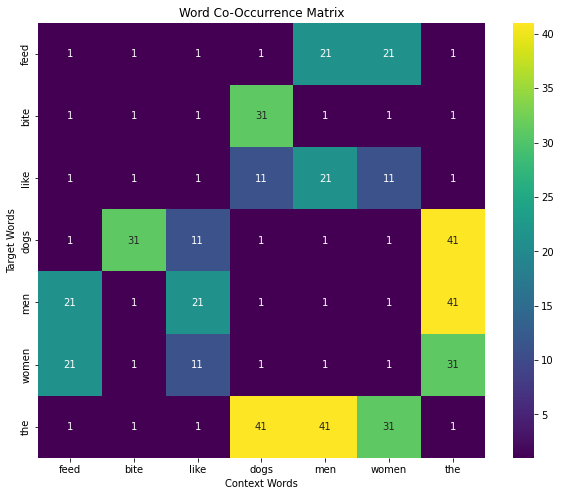

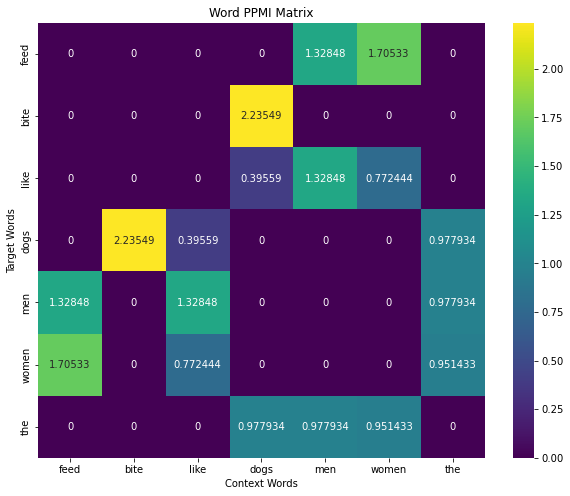

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'cm' is your co-occurrence matrix and 'voc' is your vocabulary list

# Convert the co-occurrence matrix to a DataFrame for better labeling in Seaborn
import pandas as pd
cm_df = pd.DataFrame(cm, index=voc, columns=voc)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="g", cmap="viridis")

plt.title("Word Co-Occurrence Matrix")
plt.xlabel("Context Words")
plt.ylabel("Target Words")
plt.show()


PPMI_df = pd.DataFrame(PPMI, index=voc, columns=voc)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(PPMI_df, annot=True, fmt="g", cmap="viridis")

plt.title("Word PPMI Matrix")
plt.xlabel("Context Words")
plt.ylabel("Target Words")
plt.show()

## Comparing "dogs " before and after PPMI reweighting

What happened to the elements of this vector that had a smoothed count of 1 in the smoothed count matrix? What happened to the elements of this vector that had the same value (not 1) in the smoothed count matrix? You can look at the indices of these numbers in the word vector and determine what context word c they correspond to.


Does it seem like PPMI reweighting did the right thing with regard to the representation of each context word c in the word vector for “dogs”? Why? Explain in a few sentences how PPMI helps (short prose will do here; no need to show any math,rather just an intuitive understanding).


In [96]:
# Original co-occurrence matrix vector
cm[voc_dict["dogs"]]

array([ 1., 31., 11.,  1.,  1.,  1., 41.])

In [97]:
# Original co-occurrence matrix vector
PPMI[voc_dict["dogs"]]

array([0.        , 2.2354901 , 0.39558993, 0.        , 0.        ,
       0.        , 0.97793444])

Questions:

**What happened to the elements of this vector that had a smoothed count of 1 in the smoothed count matrix? What happened to the elements of this vector that had the same value (not 1) in the smoothed count matrix?**

**Does it seem like PPMI reweighting did the right thing with regard to the representation of each context word c in the word vector for “dogs”? Why?**


These have been transformed to 0. The PPMI calculation seems to consider these co-occurrences as non-statistically significant about the relationship between "dogs" and these particular context words. If we look at these words we see they are 'dogs', 'men', and 'women'. We can see that these words don't co-occur with 'dogs' in our dataset.


For the co-occuring words with larger values, it seems the PPMI transformation has down-weighted these values but kept them positive based on how informative the pairs are. So while these words do co-occur with "dogs", their co-occurrence is not as uniquely informative as it might be for rarer word pairs so the word 'bite' we see shows the most information and then 'like' and then 'feed'.

The PPMI transformation of the word vector for "dogs" seems to have highlighted more meaningful and significant relationships while filtering out less informative ones. This makes the vectors more useful for tasks like semantic analysi since they better represent the word associations rather than just raw co-occurrence counts.

## Now that we have the semantic model, let's use it to do some semantic analysis

Compute the Euclidean (not cosine
as was done in Lecture 22) distance between the following pairs (you
can use the command scipy.linalg.norm to compute the length-
/norm of a vector):

    – “women” and “men” (human noun vs. human noun)
    – “women” and “dogs” (human noun vs. animal noun)
    – “men” and “dogs” (human noun vs. animal noun)
    – “feed” and “like” (human verb vs. human verb)
    – “feed” and “bite” (human verb vs. animal verb)
    – “like” and “bite” (human verb vs. animal verb)

Do the distances you compute above confirm our intuition from distributional semantics (i.e., similar words appear in similar contexts)?

In [98]:
def euclidean_dist(x,y):
    return np.sqrt(np.sum((x-y)**2))

# or 

from scipy.linalg import norm

def euclidean_dist_using_norm(x, y):
    return norm(x - y)


## Trying the distances with the original co-occurrence matrix

In [99]:
print('cm: "women" and "men" = ', euclidean_dist_using_norm(cm[voc_dict["women"]],cm[voc_dict["men"]]))
print('cm: "women" and "dogs" = ', euclidean_dist_using_norm(cm[voc_dict["women"]],cm[voc_dict["dogs"]]))
print('cm: "men" and "dogs" = ', euclidean_dist_using_norm(cm[voc_dict["men"]],cm[voc_dict["dogs"]]))
print('cm: "feed" and "like" = ', euclidean_dist_using_norm(cm[voc_dict["feed"]],cm[voc_dict["like"]]))
print('cm: "feed" and "bite" = ', euclidean_dist_using_norm(cm[voc_dict["feed"]],cm[voc_dict["bite"]]))
print('cm: "like" and "bite" = ', euclidean_dist_using_norm(cm[voc_dict["like"]],cm[voc_dict["bite"]]))

cm: "women" and "men" =  14.142135623730951
cm: "women" and "dogs" =  37.41657386773941
cm: "men" and "dogs" =  37.41657386773941
cm: "feed" and "like" =  14.142135623730951
cm: "feed" and "bite" =  41.23105625617661
cm: "like" and "bite" =  30.0


# Distances with the PPMI matrix

In [100]:
print('PPMI: "women" and "men" = ', euclidean_dist_using_norm(PPMI[voc_dict["women"]],PPMI[voc_dict["men"]]))
print('PPMI: "women" and "dogs" = ', euclidean_dist_using_norm(PPMI[voc_dict["women"]],PPMI[voc_dict["dogs"]]))
print('PPMI: "men" and "dogs" = ', euclidean_dist_using_norm(PPMI[voc_dict["men"]],PPMI[voc_dict["dogs"]]))
print('PPMI: "feed" and "like" = ', euclidean_dist_using_norm(PPMI[voc_dict["feed"]],PPMI[voc_dict["like"]]))
print('PPMI: "feed" and "bite" = ', euclidean_dist_using_norm(PPMI[voc_dict["feed"]],PPMI[voc_dict["bite"]]))
print('PPMI: "like" and "bite" = ', euclidean_dist_using_norm(PPMI[voc_dict["like"]],PPMI[voc_dict["bite"]]))

PPMI: "women" and "men" =  0.6722295134140552
PPMI: "women" and "dogs" =  2.8369504799818044
PPMI: "men" and "dogs" =  2.7627051405775784
PPMI: "feed" and "like" =  1.013295274424649
PPMI: "feed" and "bite" =  3.1097289754108073
PPMI: "like" and "bite" =  2.397238102632185


**Do the distances you compute above confirm our intuition from distributional semantics (i.e., similar words appear in similar contexts)?**

Yes, the words that have a smaller euclidean distance seem to be similar in how they are used. So "women" and "men" are very similar in the vector space whereas "feed" and "bite" are quite far. If the corpus was much larger, we could expect this technique to help us understand how words in a language are used in context.

## Decompose the matrix using SVD 

 Decompose the matrix using singular-value decomposition (SVD) by using the command scipy.linalg.svd, using the commands given below. 

In [101]:
import scipy

U, E, Vt = scipy.linalg.svd(PPMI, full_matrices=False)
U = np.matrix(U) # compute U
# print('U:\n ', U)
E = np.matrix(np.diag(E)) # compute E
# print('E:\n ', E)
Vt = np.matrix(Vt) # compute Vt = conjugate transpose of V
# print('Vt:\n ', Vt)
V = Vt.T # compute V = conjugate transpose of Vt
# print('V:\n ', V)

Verify I can recover the original matrix by multiplying U, E, and Vt together.

In [102]:
reconstructed_PPMI = U @ E @ Vt
print(reconstructed_PPMI)
print(PPMI)

[[ 4.88049220e-17 -1.27637717e-16  9.18204033e-17  1.00180281e-16
   1.32847573e+00  1.70533004e+00  1.93783907e-17]
 [-2.00848610e-17 -6.98767099e-16  7.83388981e-17  2.23549010e+00
  -2.02962647e-16  4.77048956e-16 -1.43384142e-16]
 [-1.92018992e-17 -7.08473208e-17 -3.19824162e-17  3.95589926e-01
   1.32847573e+00  7.72444231e-01  1.17491587e-16]
 [-4.25007252e-17  2.23549010e+00  3.95589926e-01  4.80626823e-16
   6.36643516e-16  4.61436445e-16  9.77934444e-01]
 [ 1.32847573e+00 -1.38777878e-16  1.32847573e+00 -1.86482774e-16
  -1.66533454e-16 -1.94289029e-16  9.77934444e-01]
 [ 1.70533004e+00  6.24500451e-17  7.72444231e-01 -5.23886490e-16
  -3.74700271e-16 -3.74700271e-16  9.51433055e-01]
 [-4.47405706e-18 -3.30522164e-18 -7.84218438e-18  9.77934444e-01
   9.77934444e-01  9.51433055e-01  1.35439871e-17]]
[[0.         0.         0.         0.         1.32847573 1.70533004
  0.        ]
 [0.         0.         0.         2.2354901  0.         0.
  0.        ]
 [0.         0.         

### Are these values close enough to the original matrix?

Yes. Using the allclose method which I found, we can see that the values are close enough to the original matrix.

In [103]:
# Check if the reconstructed matrix is close to the original
np.allclose(PPMI, reconstructed_PPMI)

True

## Reduce dimensions to 3 to get word vectors

This way our word vectors will be in the abstract semantic space.

In [104]:
reduced_PPMI = PPMI @ Vt.T[:, 0:3]
reduced_PPMI

matrix([[ 1.88740095e+00,  5.54919229e-17,  4.64653038e-16],
        [ 1.05591607e+00,  2.36555387e-16,  1.62874201e-15],
        [ 1.50093431e+00,  7.71320286e-17,  5.96987265e-16],
        [ 1.16409283e-15, -1.47115214e+00, -1.98639674e+00],
        [-2.30346933e-16, -1.96787131e+00,  7.09029247e-01],
        [-2.90587370e-16, -1.91412309e+00,  7.97761399e-01],
        [ 1.66452047e+00,  1.37745174e-16,  1.00376884e-15]])

### Visualize the word vectors now that they are in 3D space

Out of curiosity I wanted to see what this reduced dimensionality matrix space looks like.

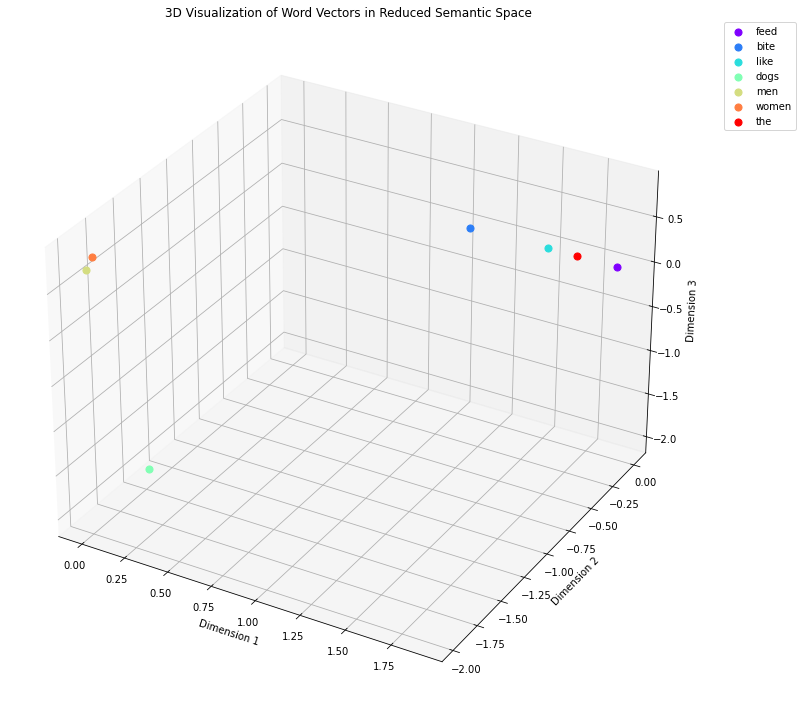

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Extract the coords of each word vector
x_coords = reduced_PPMI[:, 0].flat  # we use .flat to get a 1D iterator instead of a 2D array
y_coords = reduced_PPMI[:, 1].flat
z_coords = reduced_PPMI[:, 2].flat

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Make it pretty
colors = plt.cm.rainbow(np.linspace(0, 1, len(voc)))

# Make it legible
point_size = 50  # You can adjust this value as needed

# Scatter plot
for word, x, y, z, color in zip(voc, x_coords, y_coords, z_coords, colors):
    ax.scatter(x, y, z, color=color, label=word, s=point_size)

# Set labels
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Title
ax.set_title('3D Visualization of Word Vectors in Reduced Semantic Space')

# legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Make it prettieer
plt.tight_layout()

plt.show()


### Compute the Euclidean distances of the human/animal nouns/verbs again but on the reduced PPMI-weighted count matrix. 

**Does the compact/reduced matrix still keep the information we need for each word vector?**


In [106]:
print('reduced_PPMI: "women" and "men" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["women"]],reduced_PPMI[voc_dict["men"]]))
print('reduced_PPMI: "women" and "dogs" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["women"]],reduced_PPMI[voc_dict["dogs"]]))
print('reduced_PPMI: "men" and "dogs" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["men"]],reduced_PPMI[voc_dict["dogs"]]))
print('reduced_PPMI: "feed" and "like" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["feed"]],reduced_PPMI[voc_dict["like"]]))
print('reduced_PPMI: "feed" and "bite" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["feed"]],reduced_PPMI[voc_dict["bite"]]))
print('reduced_PPMI: "like" and "bite" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["like"]],reduced_PPMI[voc_dict["bite"]]))

reduced_PPMI: "women" and "men" =  0.10374134044303579
reduced_PPMI: "women" and "dogs" =  2.819177152431045
reduced_PPMI: "men" and "dogs" =  2.7408121413352577
reduced_PPMI: "feed" and "like" =  0.3864666418001703
reduced_PPMI: "feed" and "bite" =  0.8314848769233814
reduced_PPMI: "like" and "bite" =  0.44501823512321104


Based on the results and the visualization, it seems like the reduced matrix still keeps the information we need for each word vector. The distances between the words are still similar to the original matrix. The visualization also shows that the words are still clustered in a similar way to the original matrix.

## 2) Computing with distributional semantic word vectors

We are given two types of word vectors:

1) Classical distributional semantic matrix. The matrix is trained using a 2-word context window, PPMI weighting, and SVD reduction to 500 dimensions. The co-occurrence statistics are computed from the British National Corpus and the Web-As-Corpus. It is trained by the COMPOSES toolkit. You could in fact make your own using the pipeline from Section 1, but SVD takes hours in a realistic setting—cubic time (O(n^3)) in the number of dimensions.

2) Google’s 300-dimensional word vectors trained by deep learning. The version we provide is trained on the Google News corpus and taken from the word2vec toolkit. We will see how their word vectors fare against the more classical method.


### Read in the word vectors

In [126]:
def load_word_vectors(file_path):
    word_vectors = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_vectors[word] = vector
    return word_vectors

google_word_vectors = load_word_vectors('./EN-wform.w.2.ppmi.svd.500.rcv_vocab.txt')
EN_wform_vectors = load_word_vectors('./EN-wform.w.2.ppmi.svd.500.rcv_vocab.txt')


### Read and parse the SAT analogy questions


In [127]:
def parse_sat_questions(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    questions = []
    i = 0
    while i < len(lines):
        line = lines[i].strip()

        # Skip blank lines and commented lines
        if not line or line.startswith("#"):
            i += 1
            continue

        # Skip the header line of each question block
        i += 1

        # Read the question line (second line of the block)
        question_line = lines[i].strip().split()
        question_pair = tuple(question_line[:2])
        question_pos = tuple(question_line[2:])
        i += 1

        # Read the choices (next 5 lines)
        choices = []
        pos_pairs = []
        for j in range(5):
            choice_line = lines[i].strip().split()
            choice_pair = tuple(choice_line[:2])
            pos_pair = tuple(choice_line[2:])
            choices.append(choice_pair)
            pos_pairs.append(pos_pair)
            i += 1

        # Read the correct answer (8th line of the block)
        answer = lines[i].strip().lower()
        answer_index = ord(answer) - ord('a')  # convert it to a num
        i += 1

        questions.append({
            'prompt': question_pair,
            'choices': choices,
            'answer': answer_index,
            'part_of_speech': (question_pos, pos_pairs)
        })

        # Skip the blank line after each block
        i += 1

    return questions


sat_questions = parse_sat_questions('SAT-package-V3.txt')



In [128]:
sat_questions[0]

# Ok, it looks good.

{'prompt': ('lull', 'trust'),
 'choices': [('balk', 'fortitude'),
  ('betray', 'loyalty'),
  ('cajole', 'compliance'),
  ('hinder', 'destination'),
  ('soothe', 'passion')],
 'answer': 2,
 'part_of_speech': (('v:n',),
  [('v:n',), ('v:n',), ('v:n',), ('v:n',), ('v:n',)])}

## Handling unknown words using SAT question average vectors

If we encounter an unknown word, add all the vectors in the SAT question in the corresponding position (ie. if an unknown word is the left of the two choices, as in 'lull' in (('lull', 'trust')) take all the left words) that are known, and then divide by the total to get an average vector. Then use that average vector for the <unk> word.

This approach hopefully ensures that for each SAT question, unknown word are handled by using the average vector of the known words in the same position (left or right) within that specific question. This method may help provide a contextually relevant way to handle unknown words, tailored to the semantic content of each individual SAT question. 

This is opposed to just taking the part of speech tag and using the global vector average for that PoS tag.


In [129]:
def calculate_average_vectors_for_each_question(sat_questions, word_vectors):
    question_averages = []

    for question in sat_questions:
        sum_left, sum_right = np.zeros_like(next(iter(word_vectors.values()))), np.zeros_like(next(iter(word_vectors.values())))
        count_left, count_right = 0, 0

        for pair in [question['prompt']] + question['choices']:
            left_word, right_word = pair

            if left_word in word_vectors:
                sum_left += word_vectors[left_word]
                count_left += 1

            if right_word in word_vectors:
                sum_right += word_vectors[right_word]
                count_right += 1

        avg_left = sum_left / count_left if count_left > 0 else np.zeros_like(sum_left)
        avg_right = sum_right / count_right if count_right > 0 else np.zeros_like(sum_right)
        question_averages.append((avg_left, avg_right))

    return question_averages


def get_vector_with_fallback(word_vectors, word, position, question_average_vectors):
    if word in word_vectors:
        return word_vectors[word]
    return question_average_vectors[0] if position == 'left' else question_average_vectors[1]


## Let's try using cosine similarity to find the most similar word to the analogy

I used this in a Spotify recommendation project so I want to give it a shot here.

In [130]:
import numpy as np
from scipy.spatial.distance import cosine


def cosine_similarity_between_words(word_vectors, word1, word2, position1, position2, average_vectors):
    """Calculate the cosine similarity between two words, handling unknown words."""
    vector1 = get_vector_with_fallback(word_vectors, word1, position1, average_vectors)
    vector2 = get_vector_with_fallback(word_vectors, word2, position2, average_vectors)
    
    # Cosine similarity is 1 - cosine distance
    similarity = 1 - cosine(vector1, vector2)
    return similarity

In [138]:
def predict_answer(question, word_vectors, question_average_vectors):
    # Calculate the vector for the stem pair (the prompt)
    stem_vector = cosine_similarity_between_words(
        word_vectors, question['prompt'][0], question['prompt'][1], 
        'left', 'right', question_average_vectors)

    # Initialize variables to store the best choice and its similarity score
    best_choice = None
    best_similarity = -1

    # Compare with each choice pair
    for i, choice in enumerate(question['choices']):
        choice_vector = cosine_similarity_between_words(
            word_vectors, choice[0], choice[1], 
            'left', 'right', question_average_vectors)

        # Calculate the similarity with the stem vector
        similarity = 1 - cosine(stem_vector, choice_vector)

        # If the similarity is higher than the current best, update
        if similarity > best_similarity:
            best_similarity = similarity
            best_choice = i

    return best_choice


def evaluate_accuracy(sat_questions, word_vectors):
    correct_answers = 0
    question_averages = calculate_average_vectors_for_each_question(sat_questions, word_vectors)

    for question, averages in zip(sat_questions, question_averages):
        predicted = predict_answer(question, word_vectors, averages)
        if predicted == question['answer']:
            correct_answers += 1

    return correct_answers / len(sat_questions)

# Calculate accuracy
accuracy = evaluate_accuracy(sat_questions, google_word_vectors)
print(f"Accuracy: {accuracy}")


Accuracy: 0.16844919786096257
